In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from AutoClass import AutoClassImpute,take_norm,find_hv_genes
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
import warnings
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix1 = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix1, axis=0)) / np.sum(contingency_matrix1) 
def JaccardInd(ytrue,ypred):
    n = len(ytrue)
    a,b,c,d = 0,0,0,0
    for i in range(n-1):
        for j in range(i+1,n):
            if ((ypred[i] == ypred[j])&(ytrue[i]==ytrue[j])):
                a = a + 1
            elif ((ypred[i] == ypred[j])&(ytrue[i]!=ytrue[j])):
                b = b + 1
            elif ((ypred[i] != ypred[j])&(ytrue[i]==ytrue[j])):
                c = c + 1
            else:
                d = d + 1
    if (a==0)&(b==0)&(c==0):
        return 0
    else:
        return a/(a+b+c)
def cluster_metrics_inTop200genes(X,label):
    K = len(np.unique(label))
    warnings.filterwarnings("ignore")
    df = pd.DataFrame()
    highvar_genes = find_hv_genes(X,top=200)
    data = X[:,highvar_genes]
    kmeans = KMeans(n_clusters = K,random_state=1).fit(data)
    cluster_label = kmeans.labels_
    df['ARI'] = [np.round(adjusted_rand_score(label,cluster_label),3)]
    df['JI'] = [np.round(JaccardInd(label,cluster_label),3)]
    df['NMI'] = [np.round(normalized_mutual_info_score(label,cluster_label),3)]
    df['PS'] = [np.round(purity_score(label,cluster_label),3)]
    return df

#### Buettner datset


In [3]:
expr = pd.read_csv('C:/Users/hli45/Desktop/DATA_in_paper/Buettner.csv',index_col=0) # preprocessed data, no need to normalization
X = expr.values[:,:-1] 
label = expr.values[:,-1]
K = len(np.unique(label))
ncell,ngene = X.shape[0],X.shape[1]
print('{} cells, {} genes \n proportion of 0s: {} \n {} different cell types'.format(ncell,ngene,np.mean(X==0),K))

182 cells, 8985 genes 
 proportion of 0s: 0.379163685507592 
 3 different cell types


In [4]:
res = AutoClassImpute(X,cellwise_norm=False,log1p=False)  
cluster_metrics_inTop200genes(res['imp'],label)

182 cells and 8985 genes
number of clusters in pre-clustering:[8, 9, 10]
n_cluster = 8...
n_cluster = 9...
n_cluster = 10...
escape time is: 23.37971067428589


,ARI,JI,NMI,PS
0,0.417,0.442,0.465,0.736


#### Usoskin dataset

In [5]:
expr = pd.read_csv('C:/Users/hli45/Desktop/DATA_in_paper/Usoskin.csv',index_col=0) # preprocessed data, no need to normalization
X = expr.values[:,:-1] 
label = expr.values[:,-1]
K = len(np.unique(label))
ncell,ngene = X.shape[0],X.shape[1]
print('{} cells, {} genes \n proportion of 0s: {} \n {} different cell types'.format(ncell,ngene,np.mean(X==0),K))

622 cells, 1000 genes 
 proportion of 0s: 0.9582668810289389 
 4 different cell types


In [6]:
res = AutoClassImpute(X,cellwise_norm=False,log1p=False)
cluster_metrics_inTop200genes(res['imp'],label)

622 cells and 1000 genes
number of clusters in pre-clustering:[8, 9, 10]
n_cluster = 8...
n_cluster = 9...
n_cluster = 10...
escape time is: 13.934708595275879


,ARI,JI,NMI,PS
0,0.868,0.828,0.828,0.937


Raw data Silhouette width: 0.4620935022830963,
AutoClass imputed data Silhouette width: 0.5353405475616455


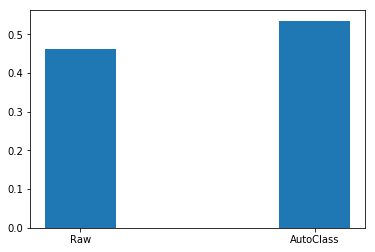

In [7]:
pca_raw = PCA(n_components=50,random_state=1).fit_transform(X)
pca_auto = PCA(n_components=50,random_state=1).fit_transform(res['imp'])
tsne_raw = TSNE(n_components=2,random_state=1).fit_transform(pca_raw)
tsne_auto = TSNE(n_components=2,random_state=1).fit_transform(pca_auto)
sil_raw = silhouette_score(tsne_raw,label)
sil_auto = silhouette_score(tsne_auto,label)
plt.bar([0,1],[sil_raw,sil_auto],
       width=0.3)
plt.xticks([0,1],['Raw','AutoClass'])
print('Raw data Silhouette width: {},\nAutoClass imputed data Silhouette width: {}'.
     format(sil_raw,sil_auto))

In [8]:
Y = [int(i) for i in label]
import random
unique_class = np.unique(Y)
K = len(unique_class)
class_id = [list(np.arange(ncell)[Y==unique_class[i]]) for i in range(K)]
from scipy.stats import pearsonr
cross_cor_raw = []
cross_cor_auto = []
imp_auto = res['imp']
runs = 200
for run in range(runs):
    i,j = random.sample(list(unique_class),2)
    ni, nj = random.sample(class_id[i-1],1)[0], random.sample(class_id[j-1],1)[0]
    cross_cor_raw.append(pearsonr(X[ni,:],X[nj,:])[0])
    cross_cor_auto.append(pearsonr(imp_auto[ni,:],imp_auto[nj,:])[0])
intra_cor_raw = []
intra_cor_auto = []

for k in range(K):
    group = np.arange(ncell)[Y==unique_class[k]]
    num = len(group)
    for i in range(num-1):
        for j in range(i+1,num):
            
            intra_cor_raw.append(pearsonr(X[group[i],:],X[group[j],:])[0])
            intra_cor_auto.append(pearsonr(imp_auto[group[i],:],imp_auto[group[j],:])[0])

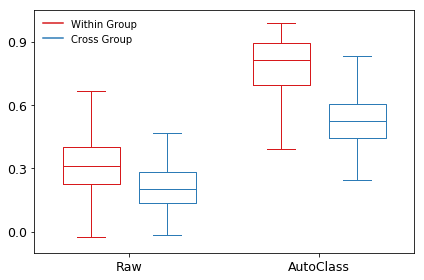

In [9]:
data_in = [intra_cor_raw,intra_cor_auto]
data_cross = [cross_cor_raw,cross_cor_auto]
ticks = ['Raw','AutoClass']
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_in, positions=np.array(range(len(data_in)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_cross, positions=np.array(range(len(data_cross)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') 
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Within Group')
plt.plot([], c='#2C7BB6', label='Cross Group')
plt.legend(frameon=False)

plt.xticks(range(0, len(ticks) * 2, 2), ticks,size=12.5)
plt.xlim(-1, len(ticks)*2-1)
plt.ylim(-0.1, 1.05)
plt.yticks([0.0,0.3,0.6,0.9],[0.0,0.3,0.6,0.9],size=12.5)
plt.tight_layout()


#### Lake data

In [10]:
expr = pd.read_csv('C:/Users/hli45/Desktop/DATA_in_paper/Lake.csv',index_col=0)
X = expr.values[:,:-1] 
label = expr.values[:,-1]
K = len(np.unique(label))
ncell,ngene = X.shape[0],X.shape[1]
print('{} cells, {} genes \n proportion of 0s: {} \n {} different cell types'.format(ncell,ngene,np.mean(X==0),K))

8592 cells, 1000 genes 
 proportion of 0s: 0.7339482076350093 
 11 different cell types


In [11]:
res = AutoClassImpute(X)
cluster_metrics_inTop200genes(res['imp'],label)

8592 cells and 1000 genes
number of clusters in pre-clustering:[8, 9, 10]
n_cluster = 8...
n_cluster = 9...
n_cluster = 10...
escape time is: 126.63837027549744


,ARI,JI,NMI,PS
0,0.557,0.439,0.669,0.769


#### Zeisel dataset

In [12]:
expr = pd.read_csv('C:/Users/hli45/Desktop/DATA_in_paper/Zeisel.csv',index_col=0)
X = expr.values[:,:-1] 
label = expr.values[:,-1]
K = len(np.unique(label))
ncell,ngene = X.shape[0],X.shape[1]
print('{} cells, {} genes \n proportion of 0s: {} \n {} different cell types'.format(ncell,ngene,np.mean(X==0),K))

3005 cells, 1000 genes 
 proportion of 0s: 0.4858179700499168 
 9 different cell types


In [13]:
res = AutoClassImpute(X)
cluster_metrics_inTop200genes(res['imp'],label)

3005 cells and 1000 genes
number of clusters in pre-clustering:[8, 9, 10]
n_cluster = 8...
n_cluster = 9...
n_cluster = 10...
escape time is: 54.86531209945679


,ARI,JI,NMI,PS
0,0.798,0.719,0.782,0.914
